In [3]:
# !python3 -m pip install -U pip setuptools wheel --break-system-packages
# !python3 -m pip install --no-cache-dir --force-reinstall "numpy==2.0.2" "matplotlib==3.9.2" --break-system-packages

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
^C


In [6]:

# # 1) Upgrade pip WITHOUT the flag (your current pip doesn’t know it yet)
# !python3 -m pip install -U pip setuptools wheel --user

# # 2) Confirm the upgraded pip is the one being used
# !python3 -m pip --version   # should show pip >= 23.x

# # 3) Now the flag will be recognized (Debian/Ubuntu “externally-managed” override)
# !python3 -m pip install --no-cache-dir --force-reinstall numpy==2.0.2 matplotlib==3.9.2 --break-system-packages


In [2]:
# === CM + Scalars Parser & Plotter — single-call function ===
# Usage:
# from your_script import analyze_and_plot_logs
# analyze_and_plot_logs("/path/to/outputSep24_SCC", include_folders=[])

import os, tempfile, re, ast
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Ensure Matplotlib cache is writable (HPC-safe) ---
os.environ.setdefault("MPLCONFIGDIR", os.path.join(tempfile.gettempdir(), "mplconfig"))
os.makedirs(os.environ["MPLCONFIGDIR"], exist_ok=True)

# ----------------- Small utils -----------------
def _parse_kv_line(line: str):
    if " - INFO - " in line:
        line = line.split(" - INFO - ", 1)[1]
    parts = [p.strip() for p in line.split("|")]
    out = {}
    for p in parts:
        if ":" not in p: continue
        k, v = p.split(":", 1)
        out[k.strip()] = v.strip()
    return out

def _to_int(x):
    try: return int(float(x))
    except: return None

def _to_float(x):
    try: return float(x)
    except: return None

def _compute_metrics_from_cm(cm: np.ndarray, class_names=None):
    cm = np.asarray(cm, dtype=float)
    C = cm.shape[0]
    if class_names is None:
        class_names = [f"class_{i}" for i in range(C)]
    else:
        if len(class_names) != C:
            if len(class_names) > C:
                class_names = class_names[:C]
            else:
                class_names = list(class_names) + [f"class_{i}" for i in range(len(class_names), C)]

    total = cm.sum()
    diag = np.diag(cm)
    row_sum = cm.sum(axis=1)
    col_sum = cm.sum(axis=0)

    with np.errstate(divide="ignore", invalid="ignore"):
        recall = np.divide(diag, row_sum, out=np.zeros_like(diag), where=row_sum>0)
        precision = np.divide(diag, col_sum, out=np.zeros_like(diag), where=col_sum>0)
        FP = col_sum - diag
        FN = row_sum - diag
        TN = total - (FP + FN + diag)
        specificity = np.divide(TN, (TN + FP), out=np.zeros_like(TN), where=(TN+FP)>0)
        f1 = np.divide(2*precision*recall, precision+recall, out=np.zeros_like(recall), where=(precision+recall)>0)
        bal_acc = (recall + specificity)/2.0

    overall_acc = float(diag.sum()/total) if total>0 else 0.0
    support = row_sum
    weights = np.divide(support, support.sum(), out=np.zeros_like(support), where=support.sum()>0)

    macro = {
        "macro_sens": float(np.mean(recall)),
        "macro_spec": float(np.mean(specificity)),
        "macro_prec": float(np.mean(precision)),
        "macro_f1": float(np.mean(f1)),
        "macro_bal_acc": float(np.mean(bal_acc)),
    }
    weighted = {
        "weighted_sens": float(np.sum(recall*weights)),
        "weighted_spec": float(np.sum(specificity*weights)),
        "weighted_prec": float(np.sum(precision*weights)),
        "weighted_f1": float(np.sum(f1*weights)),
        "weighted_bal_acc": float(np.sum(bal_acc*weights)),
    }

    per_class_rows = []
    for i, name in enumerate(class_names):
        prec_i = precision[i]
        per_class_rows.append({
            "class": name,
            "supp": int(support[i]),
            "sens": float(recall[i]),
            "spec": float(specificity[i]),
            "prec": float(prec_i) if np.isfinite(prec_i) else 0.0,
            "f1": float(f1[i]),
            "balAcc": float(bal_acc[i]),
        })
    return overall_acc, per_class_rows, macro, weighted

_CM_BLOCK_RE = re.compile(r"cm_(\w+):\s*(\[\[.*?\]\])")
def _parse_validation_compact_cms(lines):
    last = None
    for line in lines:
        if "type: validation" in line and "cm_" in line:
            last = line
    if last is None: return {}
    out = {}
    for m in _CM_BLOCK_RE.finditer(last):
        task = m.group(1)
        try:
            out[task] = np.array(ast.literal_eval(m.group(2)), dtype=int)
        except Exception:
            pass
    return out

_task_key_suffix = re.compile(r"_task(\d+)$")
def _find_task_ids(keys):
    ids = set()
    for k in keys:
        m = _task_key_suffix.search(k)
        if m: ids.add(int(m.group(1)))
    return sorted(ids)

def _add_rollings(df, window):
    if df.empty: return df
    df = df.sort_values(["type", "task", "iteration"]).reset_index(drop=True)
    for (typ, t), idx in df.groupby(["type", "task"]).groups.items():
        idx = list(idx)
        for col, outcol in [("loss", f"loss_ma_{window}"),
                            ("bal_acc", f"balacc_ma_{window}"),
                            ("accuracy", f"acc_ma_{window}"),
                            ("auc", f"auc_ma_{window}")]:
            if col in df.columns:
                df.loc[idx, outcol] = df.loc[idx, col].rolling(window, min_periods=1).mean()
    return df

def _parse_log_scalars(path):
    rows = []
    with open(path, "r") as f:
        for line in f:
            if "iteration:" not in line or "epoch:" not in line or "type:" not in line: continue
            if "Loss wrapper status at step" in line: continue
            kv = _parse_kv_line(line)
            iteration = _to_int(kv.get("iteration"))
            epoch = _to_int(kv.get("epoch"))
            lr = _to_float(kv.get("lr"))
            split_typ = kv.get("type")
            loss_main = _to_float(kv.get("loss", kv.get("avg_loss")))
            t_ids = _find_task_ids(kv.keys())
            if not t_ids:
                rows.append({"iteration": iteration, "epoch": epoch, "lr": lr, "type": split_typ,
                             "task": None, "loss": loss_main, "accuracy": None,
                             "sensitivity": None, "specificity": None, "auc": None})
                continue
            for t in t_ids:
                rows.append({
                    "iteration": iteration, "epoch": epoch, "lr": lr, "type": split_typ, "task": t,
                    "loss": loss_main,
                    "accuracy": _to_float(kv.get(f"acc_task{t}")),
                    "sensitivity": _to_float(kv.get(f"sens_task{t}")),
                    "specificity": _to_float(kv.get(f"spec_task{t}")),
                    "auc": _to_float(kv.get(f"auc_task{t}")),
                })
    df = pd.DataFrame(rows)
    if not df.empty:
        mask = df["sensitivity"].notna() & df["specificity"].notna()
        df.loc[mask, "bal_acc"] = (df.loc[mask, "sensitivity"] + df["specificity"]) / 2.0
    return df

# robust accumulation patterns
_ACCUM_PATS = [
    re.compile(r"Gradient\s+accumulation\s+steps\s*[:=]\s*(\d+)", re.IGNORECASE),
    re.compile(r"Grad(?:ient)?\s+accum(?:ulation)?(?:\s+steps?)?\s*[:=]\s*(\d+)", re.IGNORECASE),
    re.compile(r"accum(?:ulation)?\s*[:=]\s*(\d+)", re.IGNORECASE),
    re.compile(r"accum_steps\s*[:=]\s*(\d+)", re.IGNORECASE),
    re.compile(r"grad_accum\s*[:=]\s*(\d+)", re.IGNORECASE),
]
def _parse_grad_accum_steps(path) -> int:
    K = None
    try:
        with open(path, "r") as f:
            for line in f:
                for pat in _ACCUM_PATS:
                    m = pat.search(line)
                    if m:
                        try: K = int(m.group(1))
                        except: pass
    except FileNotFoundError:
        return 1
    return K if (K and K > 0) else 1

# legend name helper
_EXP_PAT = re.compile(
    r"^output(?P<id>\d+).*?_(?P<solver>waqas|lse)_tau(?P<tau>\d+(?:\.\d+)?)_.*?_lr(?P<lr>\d+(?:\.\d+)?)(?:_|$)(?P<loss>focal|ce)?",
    re.IGNORECASE,
)
def _shorten(name: str, max_len: int = 16) -> str:
    if len(name) <= max_len: return name
    half = (max_len - 1)//2
    return f"{name[:half]}…{name[-(max_len-half-1):]}"

def _make_short_label(exp_name: str) -> str:
    m = _EXP_PAT.match(exp_name)
    if not m: return _shorten(exp_name, 20)
    id_ = m.group("id")
    sol = (m.group("solver") or "").lower()
    tau = m.group("tau"); lr = m.group("lr")
    loss = (m.group("loss") or "").lower()
    sol_tau = f"wq_{tau}" if sol == "waqas" else f"lse{tau}"
    parts = [f"lr{lr}", sol_tau]
    if loss: parts.append(loss)
    parts.append(id_)
    return "_".join(parts)

# default class names per task
def _class_names_for_task(task: str, cm: np.ndarray):
    task_default = {
        "histology": ["is_scc", "is_adeno", "is_other"],
        "metastasis": ["is_M0", "is_M1A", "is_M1B", "is_M1C"],
        "node": ["is_N0", "is_N1", "is_N2", "is_N3"],
        "tumor": ["is_T0", "is_T1", "is_T2", "is_T3", "is_T4"],
    }
    C = cm.shape[0]
    names = task_default.get(task)
    if (not names) or (len(names) != C):
        return [f"class_{i}" for i in range(C)]
    return names

# groups to parse from logs
GROUPS = ["histology", "metastasis", "node", "tumor", "is_mw"]
GROUP_ALIASES = {"histology":"Hist","metastasis":"Meta","node":"Node","tumor":"Tumor","is_mw":"MW"}

def analyze_and_plot_logs(
    main_path: str,
    include_folders=None,            # list[str] of exact experiment dir names; None/[] => ALL
    tasks_to_summarize=None,         # which cm_* to summarize
    window: int = 5,
    max_iter: int = 300_000,
    save_summary_csv: bool = True,
    assume_batch_equals_accum: bool = True,
):
    """
    Parse training logs under `main_path/<exp>/training.log`, compute confusion-matrix summaries,
    save a full CSV, and plot smoothed group metrics (iteration ÷ accum on x-axis).

    Returns:
        results = {
          "cm_df": <full per-class/overall/macro/weighted rows or None>,
          "quick_df": <flattened overall/macro/weighted per (exp, task) or None>,
          "df_groups_all": <long df of group metrics used for plots>,
          "legend_map": {exp_name: short_label, ...},
          "exp_batch_size": {exp_name: K, ...},
          "log_paths": {exp_name: path, ...},
          "summary_csv_path": <path or None>,
        }
    """
    if tasks_to_summarize is None:
        tasks_to_summarize = ["histology", "metastasis", "node", "tumor"]
    if include_folders is None:
        include_folders = []

    # 1) discover logs
    log_paths = {}
    for exp_name in sorted(os.listdir(main_path)):
        exp_dir = os.path.join(main_path, exp_name)
        if not os.path.isdir(exp_dir): continue
        if include_folders and exp_name not in include_folders: continue
        p = os.path.join(exp_dir, "training.log")
        if os.path.exists(p): log_paths[exp_name] = p
    if not log_paths:
        raise FileNotFoundError(
            f"No training.log files found under {main_path}/* matching include_folders={include_folders or 'ALL'}"
        )

    # 2) legend labels
    LEGEND_MAP = {exp_name: _make_short_label(exp_name) for exp_name in log_paths.keys()}

    # 3) parse scalars, accum, CMs
    dfs_scalars = {}
    cm_summaries = []
    exp_batch_size = {}

    for exp_name, p in log_paths.items():
        # scalars for optional debug (not plotted directly)
        df_scalars = _add_rollings(_parse_log_scalars(p), window)
        dfs_scalars[exp_name] = df_scalars

        # gradient accumulation parsed for x-axis normalization
        K = _parse_grad_accum_steps(p) if assume_batch_equals_accum else 1
        exp_batch_size[exp_name] = K

        # compact CM blocks from final validation line
        with open(p, "r") as f:
            lines = f.readlines()
        cms = _parse_validation_compact_cms(lines)

        for task in tasks_to_summarize:
            cm = cms.get(task)
            if cm is None: continue
            class_names = _class_names_for_task(task, cm)
            overall_acc, per_class_rows, macro, weighted = _compute_metrics_from_cm(cm, class_names)
            for row in per_class_rows:
                cm_summaries.append({"experiment": exp_name, "task": task, "metric_scope": "per-class", **row})
            cm_summaries.append({"experiment": exp_name, "task": task, "metric_scope": "overall", "overall_acc": overall_acc})
            cm_summaries.append({"experiment": exp_name, "task": task, "metric_scope": "macro", **macro})
            cm_summaries.append({"experiment": exp_name, "task": task, "metric_scope": "weighted", **weighted})

    # 4) optional: print last 3 scalar rows per exp (quiet by default)
    # for name, df in dfs_scalars.items():
    #     if not df.empty:
    #         print(f"\n== {name} (last 3 parsed scalar rows) ==")
    #         print(df.tail(3))

    # 5) build CM summary frames (+ save CSV)
    cm_df = pd.DataFrame(cm_summaries) if cm_summaries else None
    quick_df = None
    summary_csv_path = None
    if cm_df is not None and not cm_df.empty:
        quick = cm_df[cm_df["metric_scope"].isin(["overall","macro","weighted"])].copy()

        def _flatten_group(g):
            rec = {"experiment": g["experiment"].iloc[0], "task": g["task"].iloc[0]}
            for _, r in g.iterrows():
                scope = r["metric_scope"]
                for k, v in r.items():
                    if k in ["experiment","task","metric_scope"] or pd.isna(v): continue
                    rec[f"{scope}_{k}"] = v
            return pd.Series(rec)

        quick_rows = []
        for (_, _), g in quick.groupby(["experiment","task"]):
            quick_rows.append(_flatten_group(g))
        quick_df = pd.DataFrame(quick_rows)

        if save_summary_csv:
            summary_csv_path = os.path.join(main_path, "validation_cm_summary.csv")
            cm_df.to_csv(summary_csv_path, index=False)

    # 6) parse group series across experiments (for plots)
    def _parse_group_series(path):
        rows = []
        with open(path, "r") as f:
            for line in f:
                if "iteration:" not in line or "epoch:" not in line or "type:" not in line: continue
                kv = _parse_kv_line(line)
                iteration = _to_int(kv.get("iteration"))
                split_typ = kv.get("type")
                rec_base = {"iteration": iteration, "type": split_typ}
                for g in GROUPS:
                    acc = _to_float(kv.get(f"acc_{g}"))
                    mba = _to_float(kv.get(f"macro_bal_acc_{g}"))
                    if mba is None:
                        ms = kv.get(f"macro_sens_{g}")
                        mp = kv.get(f"macro_spec_{g}")
                        if ms is not None and mp is not None:
                            try: mba = (float(ms)+float(mp))/2.0
                            except: mba = None
                    wba = _to_float(kv.get(f"weighted_bal_acc_{g}"))
                    if (acc is not None) or (mba is not None) or (wba is not None):
                        rows.append({**rec_base, "group": g, "acc": acc,
                                     "macro_bal_acc": mba, "weighted_bal_acc": wba})
        df = pd.DataFrame(rows)
        if df.empty: return df
        df = df.sort_values(["type","group","iteration"]).reset_index(drop=True)
        for (typ, g), idx in df.groupby(["type","group"]).groups.items():
            idx = list(idx)
            for col in ["acc","macro_bal_acc","weighted_bal_acc"]:
                if col in df.columns:
                    df.loc[idx, f"{col}_ma_{window}"] = df.loc[idx, col].rolling(window, min_periods=1).mean()
        return df

    group_dfs = []
    for exp_name, p in log_paths.items():
        dfg = _parse_group_series(p)
        if not dfg.empty:
            dfg["experiment"] = exp_name
            dfg["batch_size_for_plot"] = exp_batch_size.get(exp_name, 1)
            group_dfs.append(dfg)
    df_groups_all = pd.concat(group_dfs, ignore_index=True) if group_dfs else pd.DataFrame()

    # 7) plotting helpers
    def _has_group_series(df, col):
        return (not df.empty) and (col in df.columns) and df[col].notna().any()

    def _plot_lines(df_sub, ycol, ylabel, title):
        colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
        fig, ax = plt.subplots(figsize=(12, 6))
        any_line = False

        for gi, g in enumerate(sorted(df_sub["group"].unique())):
            gdf = df_sub[(df_sub["group"] == g) & (df_sub["iteration"] <= max_iter)]
            if gdf.empty: continue

            for exp_i, (exp_name, sdf) in enumerate(gdf.groupby("experiment")):
                sdf = sdf.sort_values("iteration").copy()
                if ycol not in sdf or sdf[ycol].isna().all(): continue
                batch_k = int(sdf["batch_size_for_plot"].iloc[0])
                x = sdf["iteration"] / max(batch_k, 1)  # x-axis normalized by accum
                y = sdf[ycol]
                ls = ["-", "--", "-.", ":"][exp_i % 4]
                short = LEGEND_MAP.get(exp_name, _shorten(exp_name, 16))
                label = f"{short}·{GROUP_ALIASES.get(g, g)}"
                ax.plot(x, y, linestyle=ls, color=colors[(gi + exp_i) % len(colors)], label=label)
                any_line = True

        if not any_line:
            plt.close(fig); return

        ax.set_xlabel("Updates  (iteration ÷ accum)")
        ax.set_ylabel(ylabel)
        ax.set_title(title)
        ax.grid(True, alpha=0.35)
        ax.legend(loc="best", frameon=False, fontsize=9)   # normal legend inside
        plt.tight_layout()
        plt.show()

    # 8) make plots
    if df_groups_all.empty:
        print("[Info] No group-level metrics (acc_*, macro_bal_acc_*, weighted_bal_acc_*) found in logs.")
    else:
        for split in ["training", "validation"]:
            sub = df_groups_all[df_groups_all["type"] == split]
            col = f"acc_ma_{window}"
            if _has_group_series(sub, col):
                _plot_lines(sub, col, "Overall Accuracy", f"{split.capitalize()} — Overall Accuracy per Group")
            col = f"macro_bal_acc_ma_{window}"
            if _has_group_series(sub, col):
                _plot_lines(sub, col, "Balanced Accuracy (Macro)", f"{split.capitalize()} — Balanced Accuracy (Macro) per Group")
            col = f"weighted_bal_acc_ma_{window}"
            if _has_group_series(sub, col):
                _plot_lines(sub, col, "Balanced Accuracy (Weighted)", f"{split.capitalize()} — Balanced Accuracy (Weighted) per Group")

    return {
        "cm_df": cm_df,
        "quick_df": quick_df,
        "df_groups_all": df_groups_all,
        "legend_map": LEGEND_MAP,
        "exp_batch_size": exp_batch_size,
        "log_paths": log_paths,
        "summary_csv_path": summary_csv_path,
    }


Matplotlib created a temporary cache directory at /tmp/matplotlib-ckv_nvq9 because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


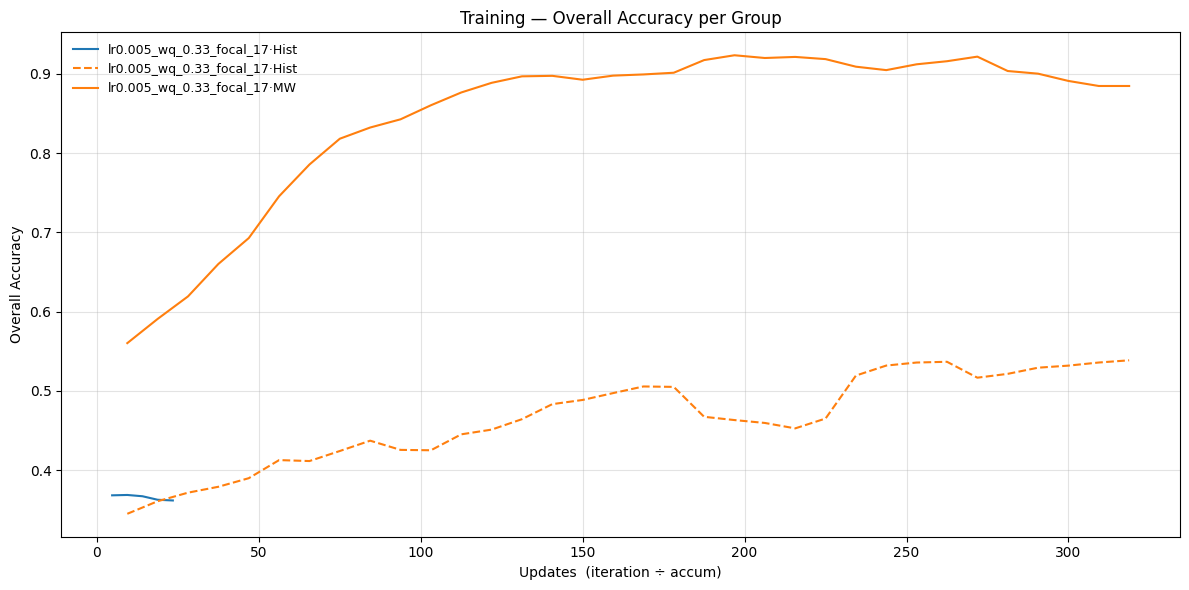

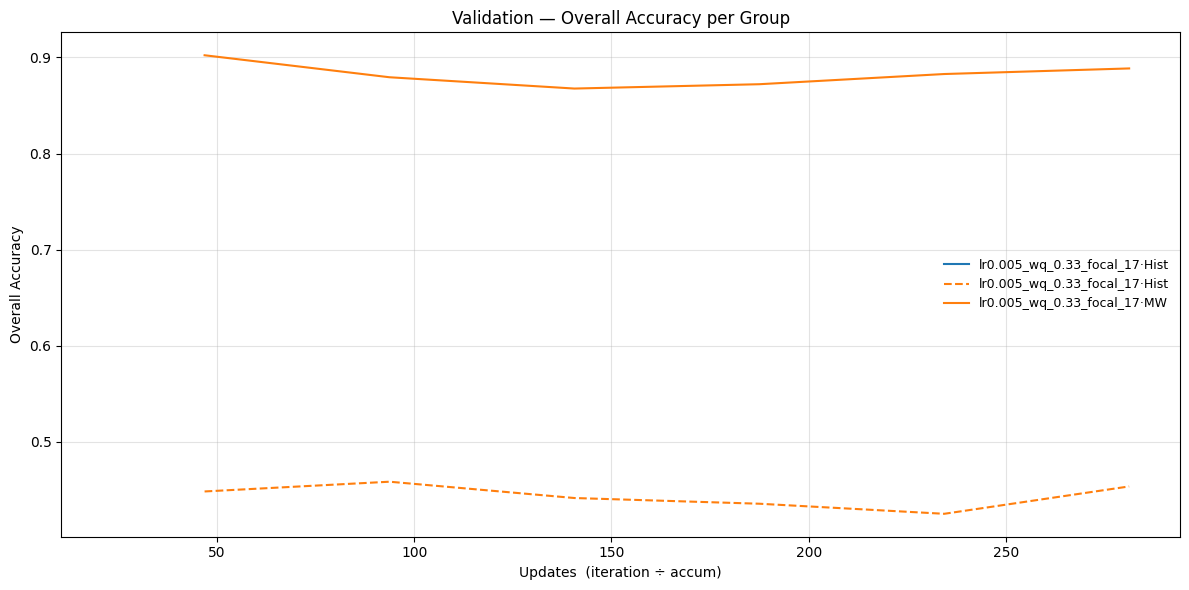

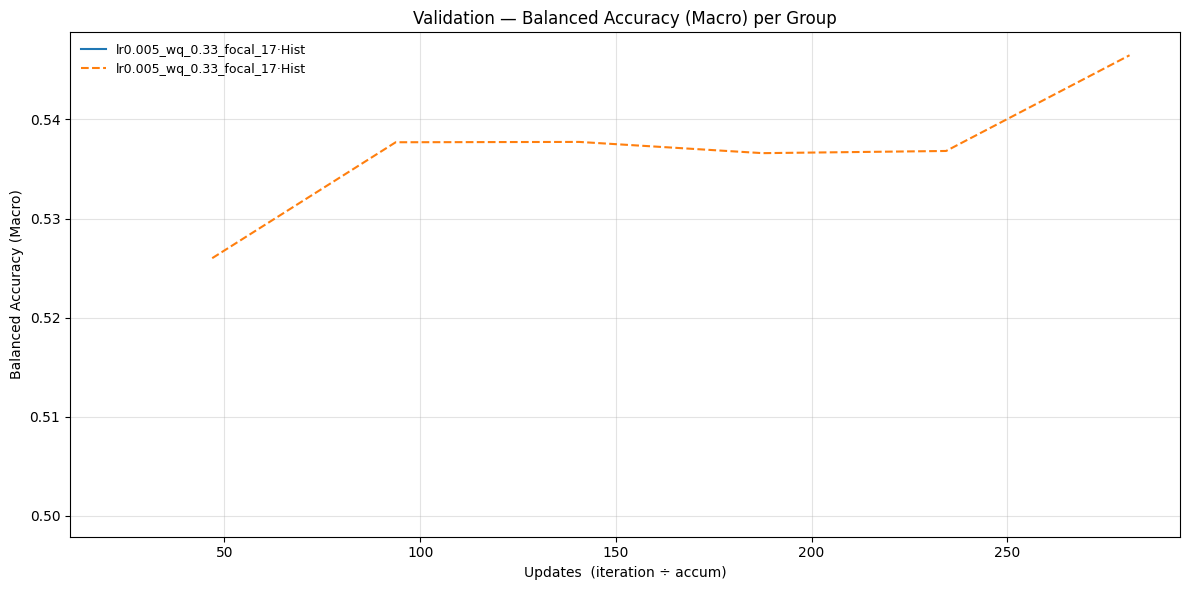

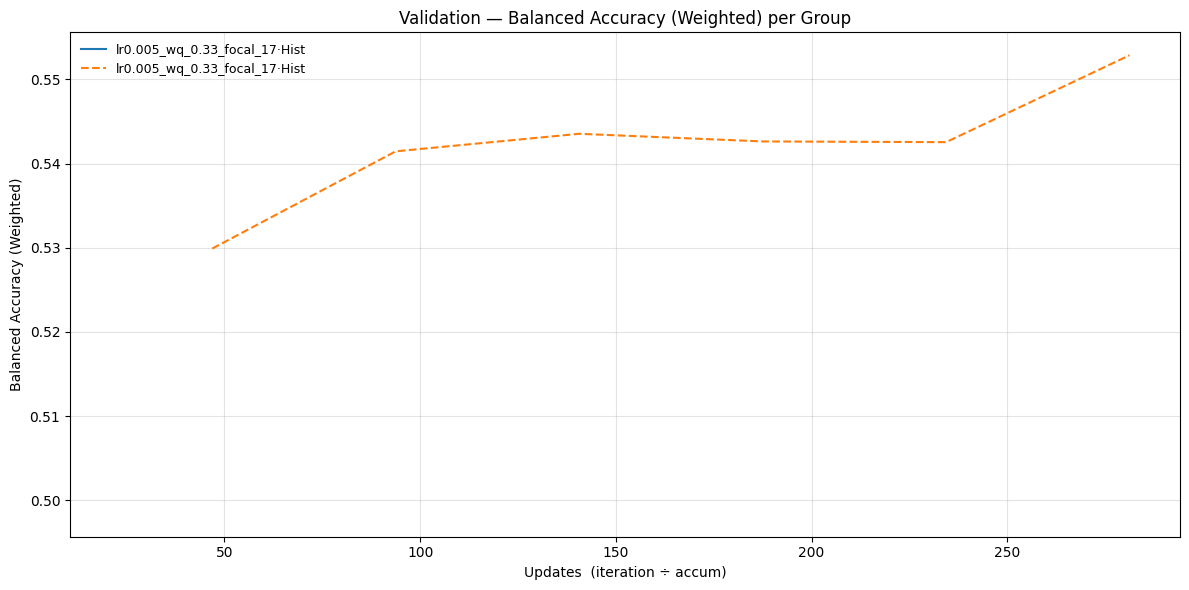

In [4]:
import os
results = analyze_and_plot_logs(
    "/rsrch7/home/ip_rsrch/wulab/Lung_Foundation_Model_Data_/Down-stream_tasks/Histology/FineTune/output/outputSep24_SCC",
    include_folders=[],        # or ["output18_..."] to filter
    window=5,
    max_iter=300000,
    save_summary_csv=True,
    assume_batch_equals_accum=True,   # x-axis uses iter ÷ accum
)

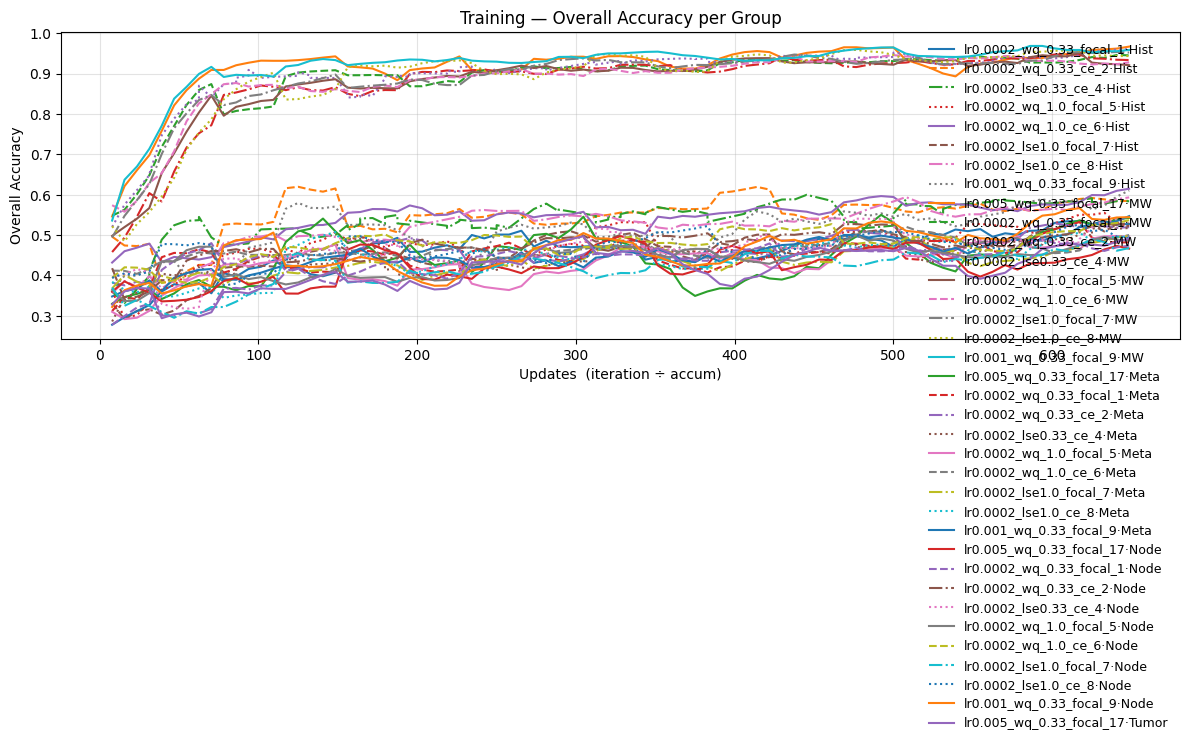

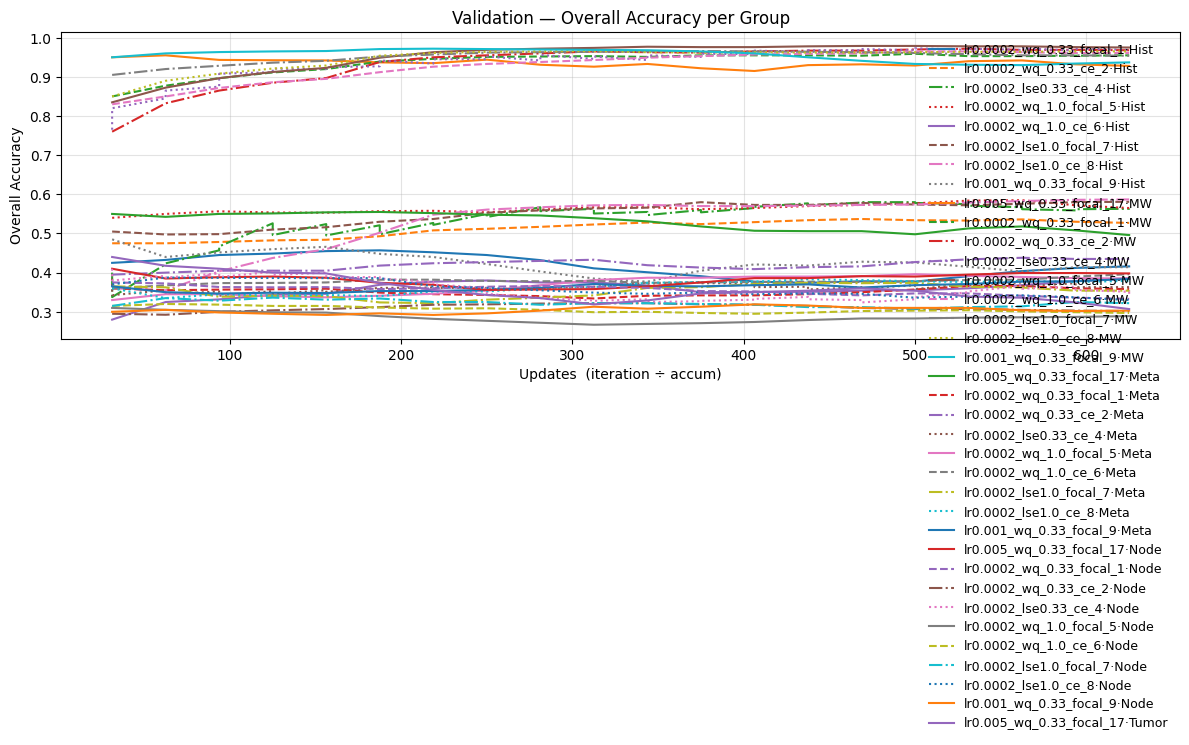

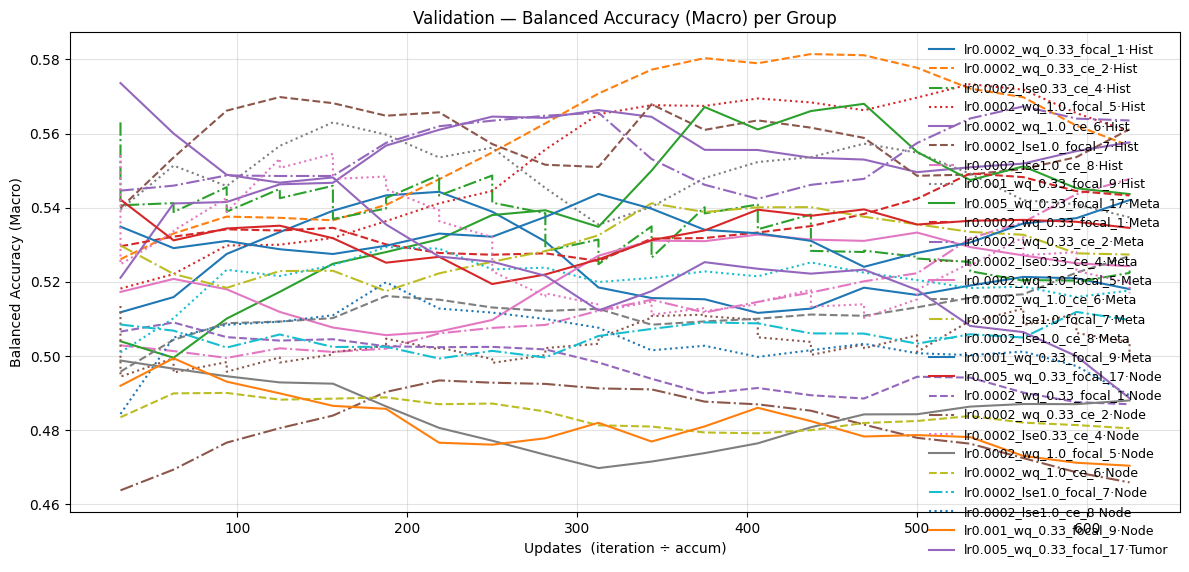

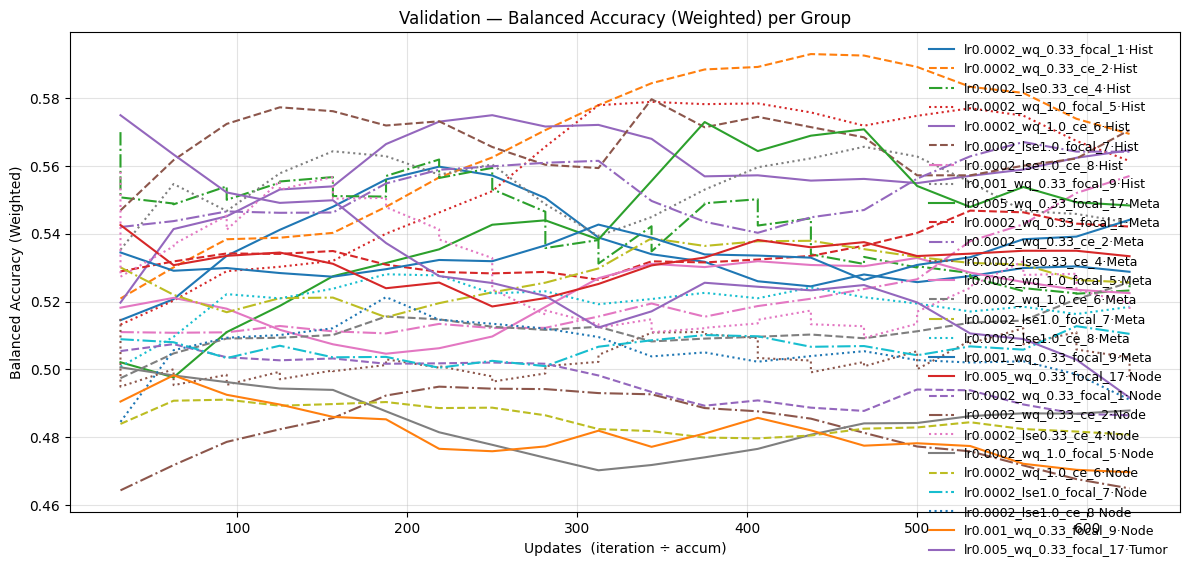

In [3]:
import os
results = analyze_and_plot_logs(
    "/rsrch7/home/ip_rsrch/wulab/Lung_Foundation_Model_Data_/Down-stream_tasks/Histology/FineTune/output/outputSep20_MNT",
    include_folders=[],        # or ["output18_..."] to filter
    window=5,
    max_iter=300000,
    save_summary_csv=True,
    assume_batch_equals_accum=True,   # x-axis uses iter ÷ accum
)

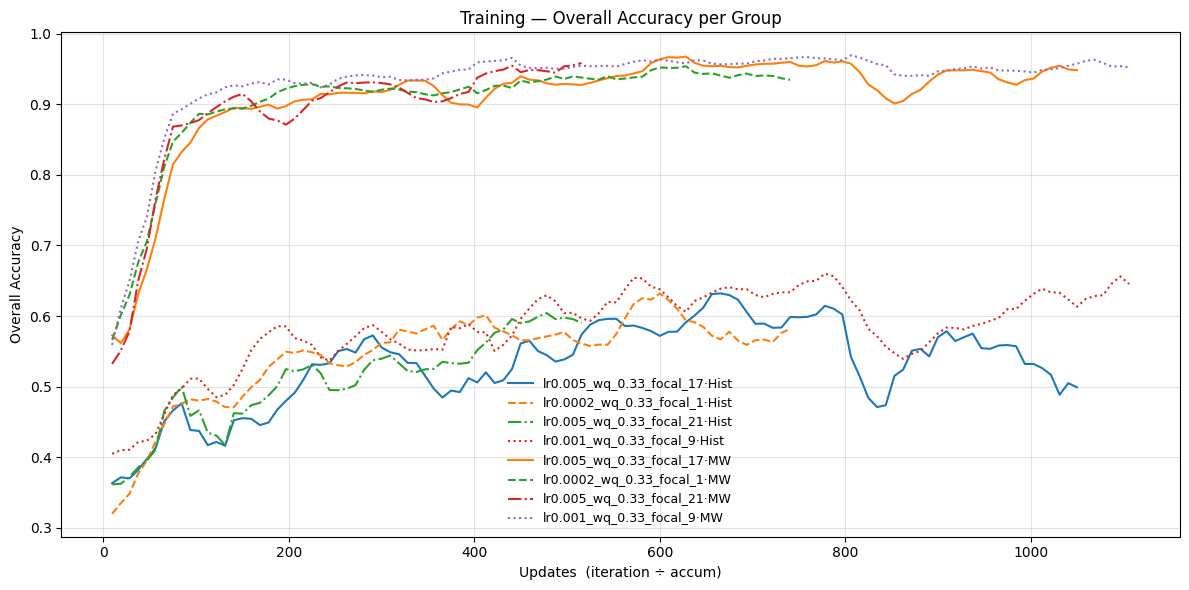

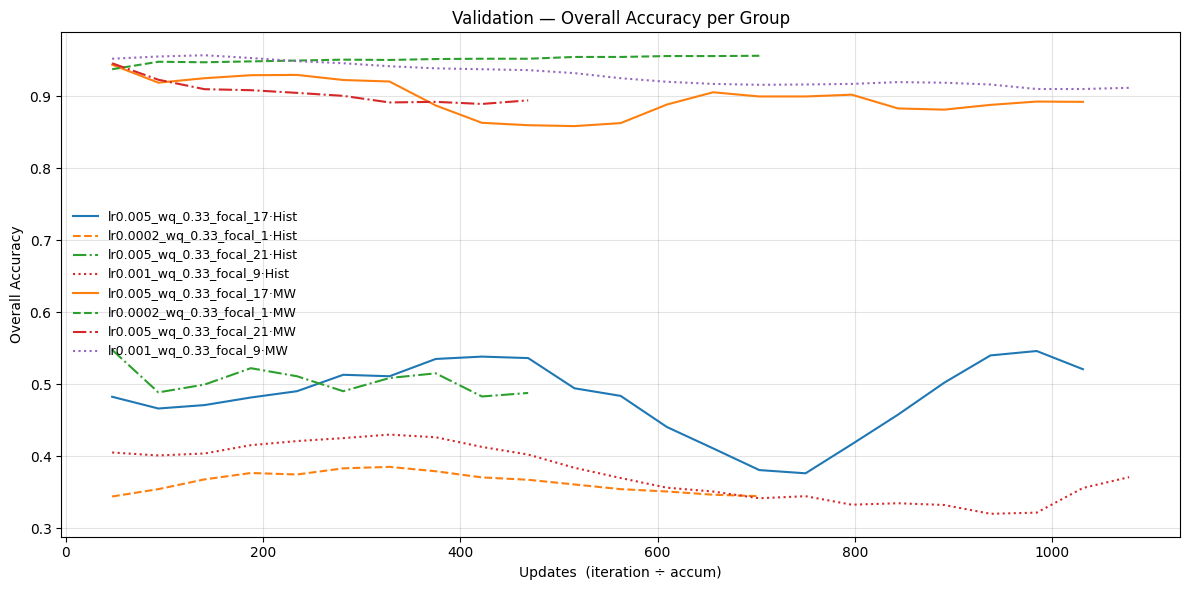

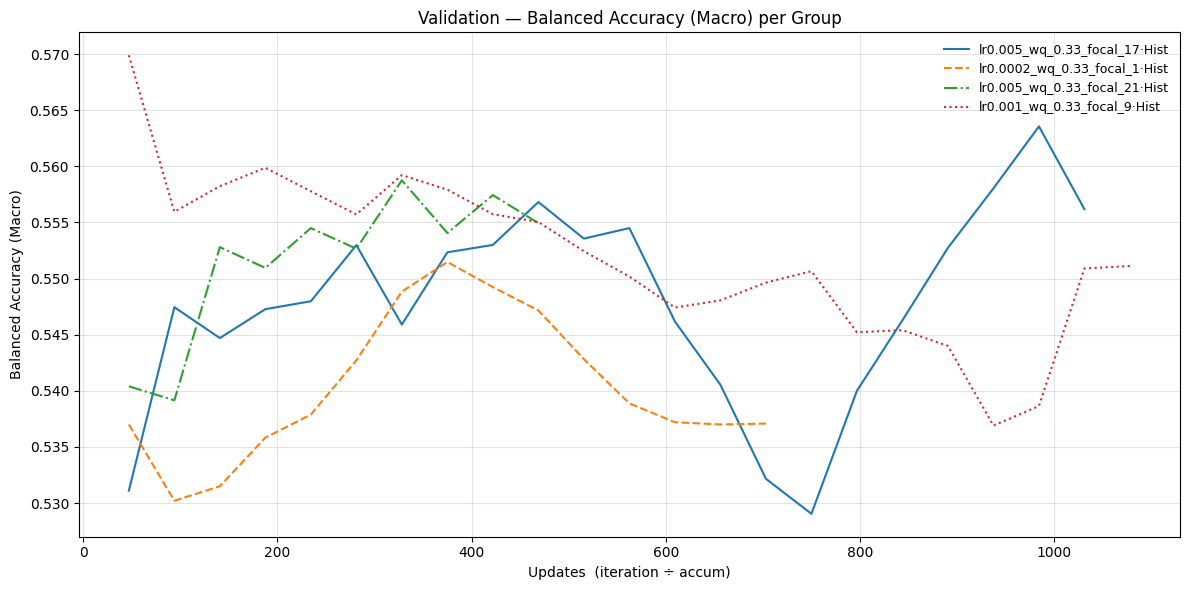

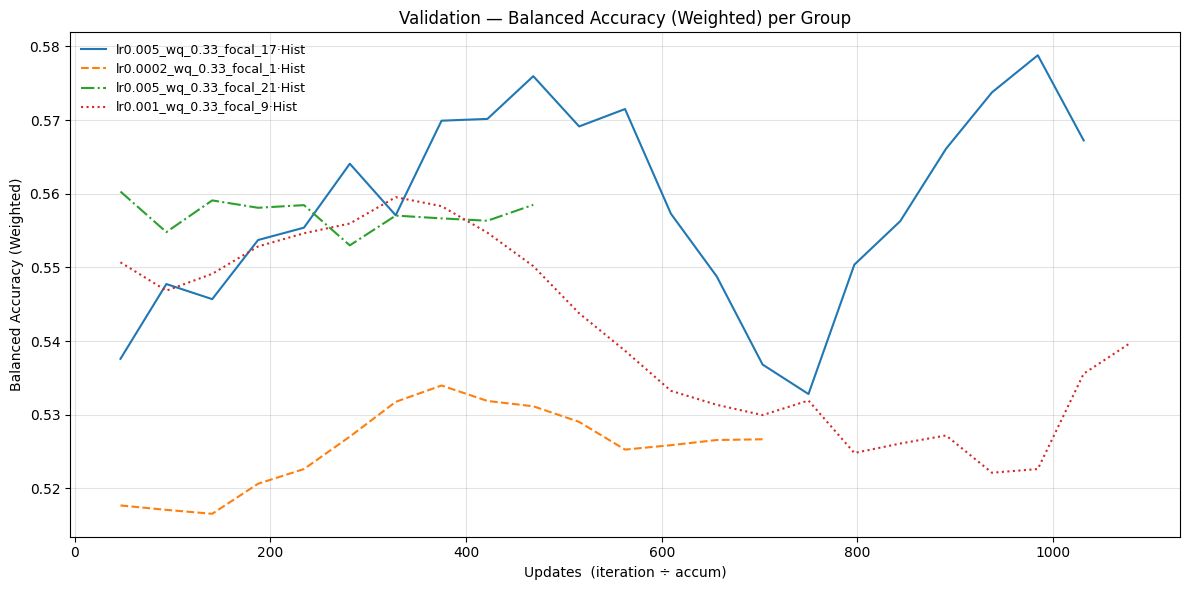

In [4]:
import os
results = analyze_and_plot_logs(
    "/rsrch7/home/ip_rsrch/wulab/Lung_Foundation_Model_Data_/Down-stream_tasks/Histology/FineTune/output/outputSep20_SCC",
    include_folders=[],        # or ["output18_..."] to filter
    window=5,
    max_iter=300000,
    save_summary_csv=True,
    assume_batch_equals_accum=True,   # x-axis uses iter ÷ accum
)